**LLama2 model from scratch without parallelization**

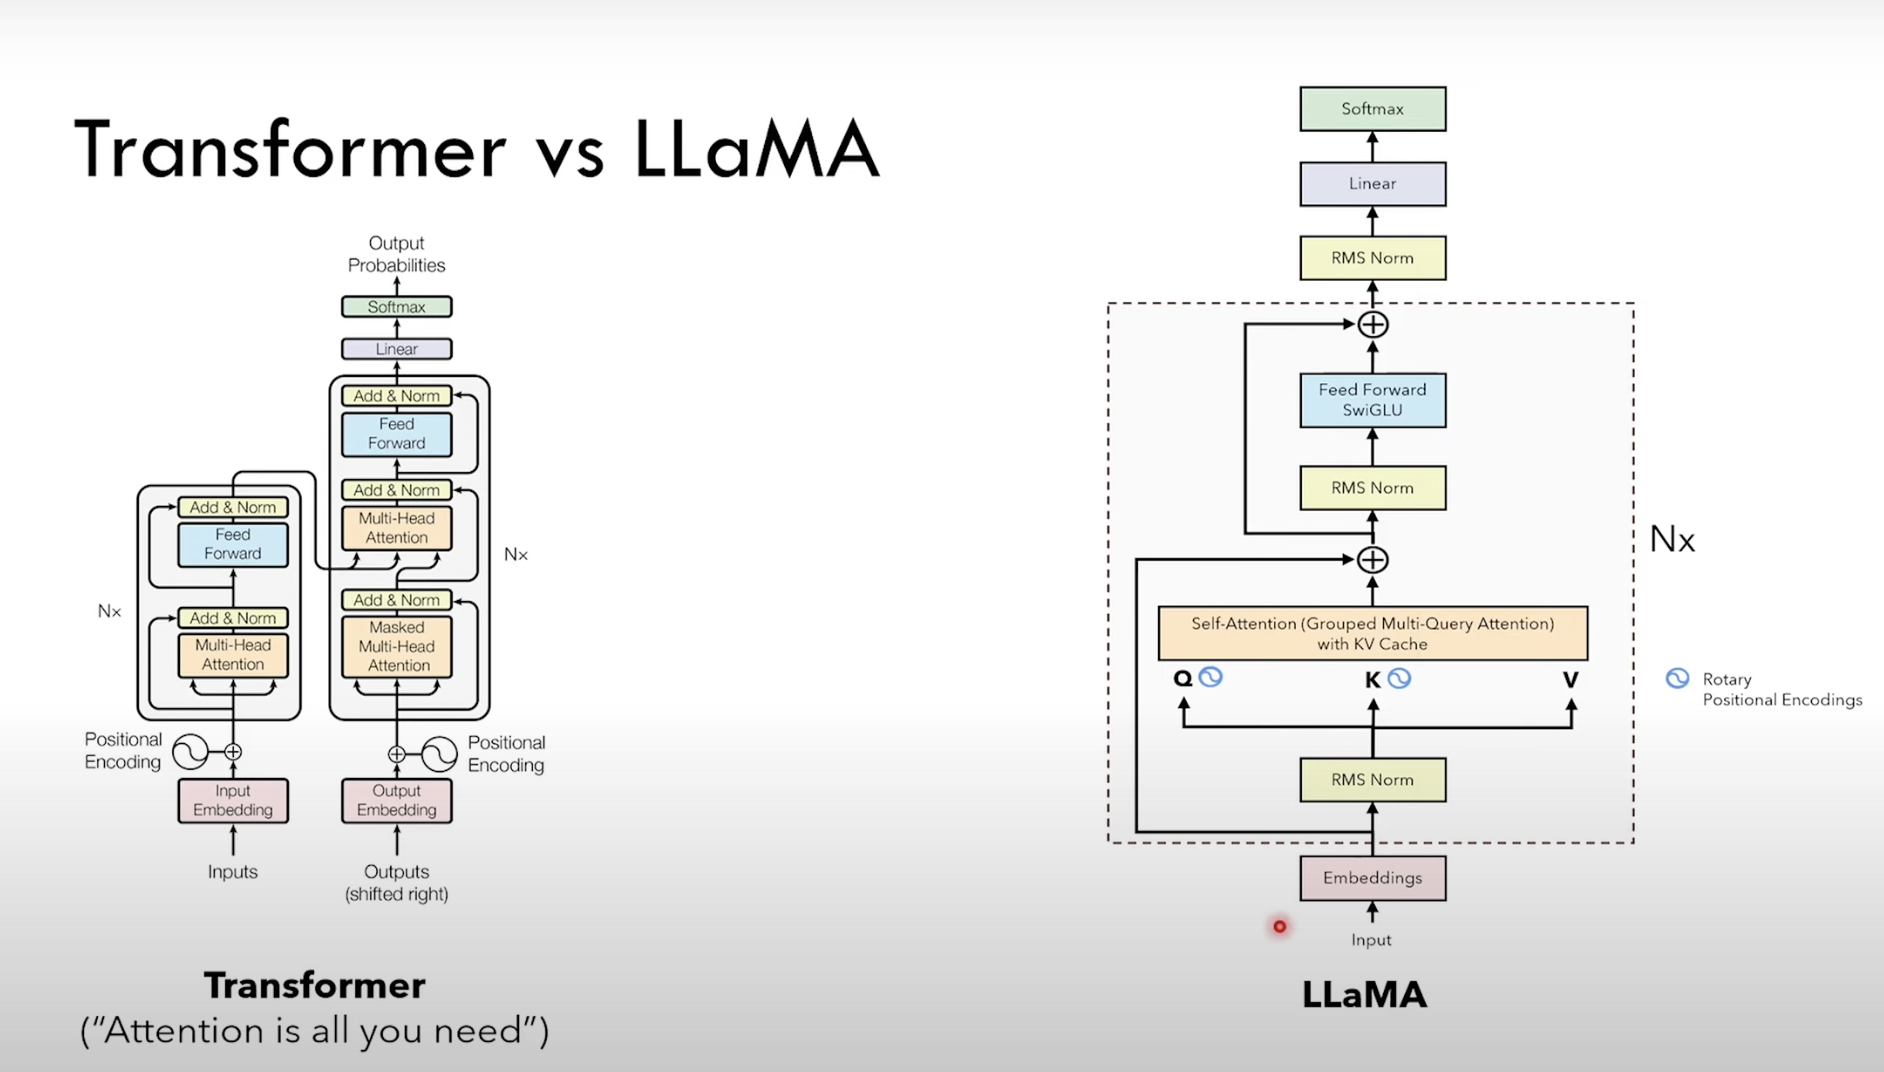

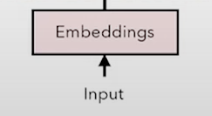

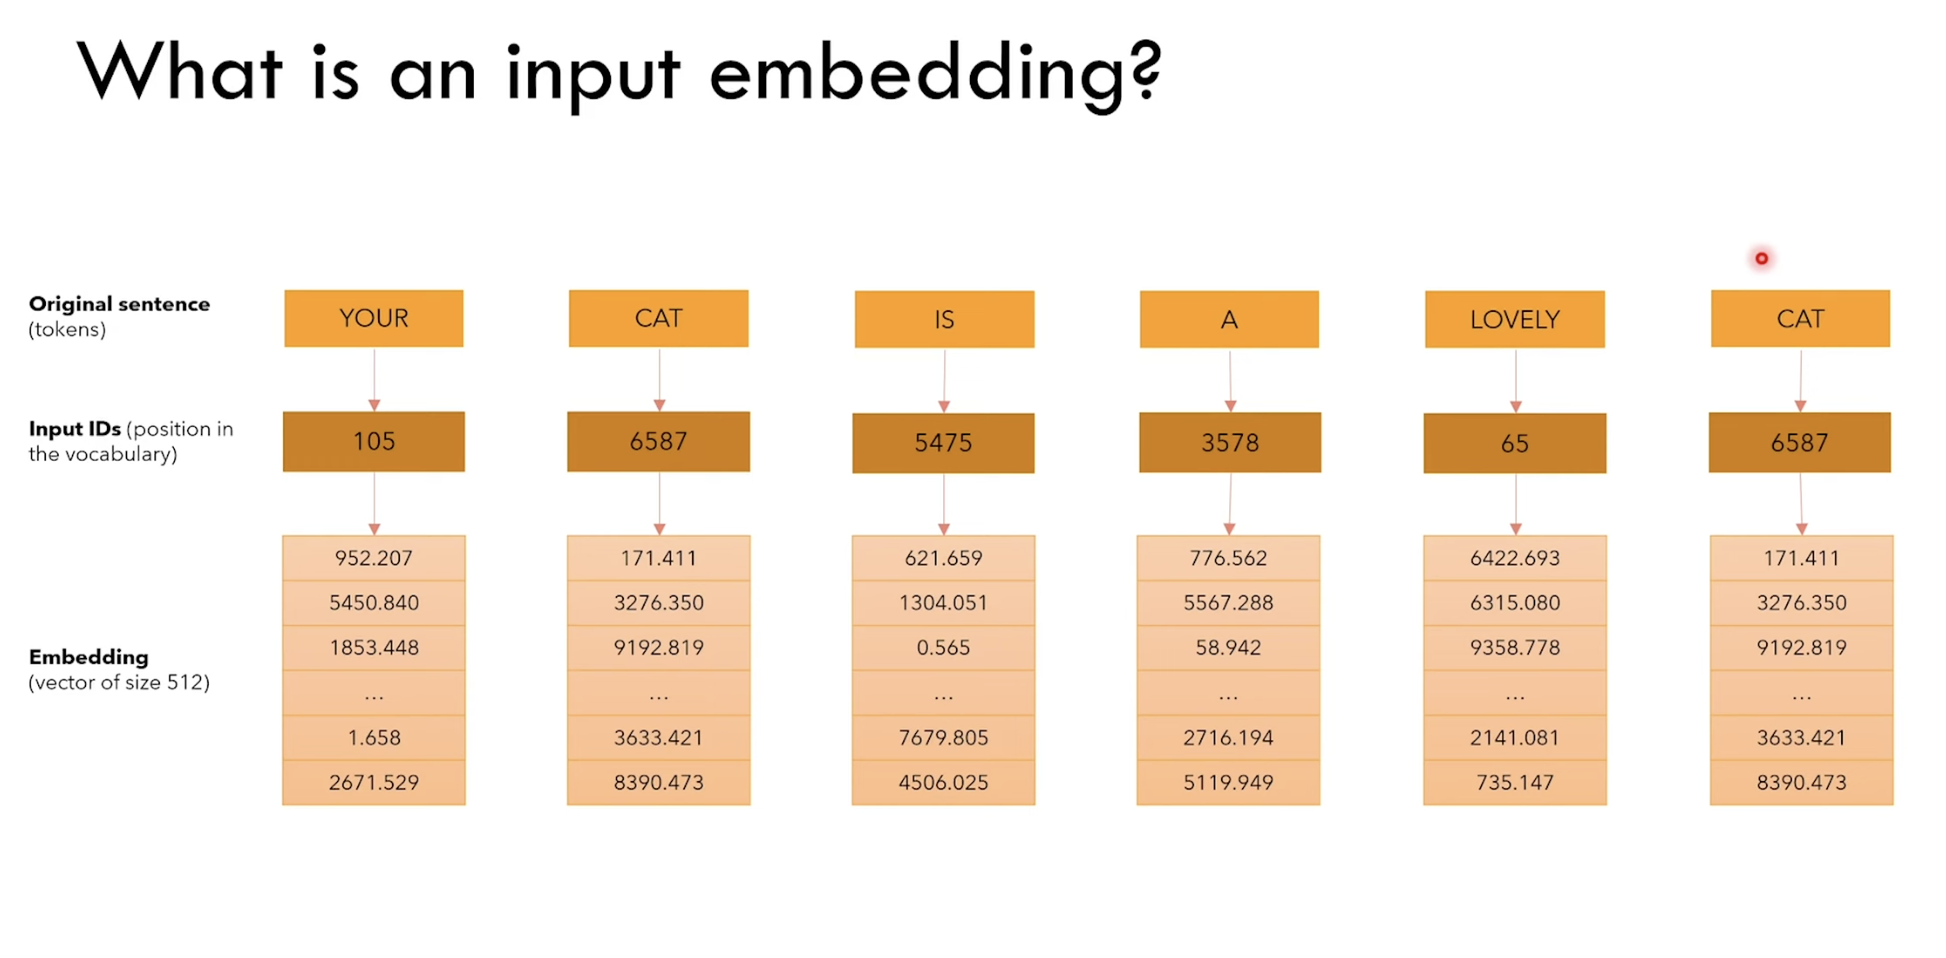

emdedding in Transformer is 512 , in Llama is 4096

The embedding can capture the meaning the word, which means the distance of two vector represente the similirity of two words.

In [4]:
import torch
import sentencepiece # tokenizer for llama
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from typing import Optional

In [5]:
@dataclass
class ModelArgs:
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32 # number of heads for Q
    n_kv_heads: Optional[int] = None #number of heads for k,v  (k,v cache),with grouped query attention
    vocab_size: int = -1 # This will be set when load tokenizer
    multiple_of: int = 256 # FF
    ffn_dim_multiplier: Optional[float] = None #FF
    norm_eps: float = 1e-5

    # Needed for KV cache
    max_batch_size: int = 32
    max_seq_len: int = 2048

    device: str = None


In [14]:
 ## the whole model , except softmax
class Transformer(nn.Module):

    def __init__(self, args: ModelArgs):
        super().__init__()

        assert args.vocab_size != -1, "Vocab size must be set"

        self.args = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        self.tok_embeddings = nn.Embedding(self.vocab_size, args.dim)

        self.layers = nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(EncoderBlock(args))

        self.norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.output = nn.Linear(args.dim, self.vocab_size, bias=False)

        self.freqs_complex = precompute_theta_pos_freq(self.args.dim // self.args.n_heads, self.args.max_seq_len * 2, device=self.args.device)

    def forward(self, tokens: torch.Tensor, start_pos: int):
        # (B, Seq_Len)
        batch_size, seq_len = tokens.shape
        ## pay attention the input token always one
        assert seq_len == 1, "Only one token at a time can be processed" ## because of kv cache

        ##Eembedding
        # (B, Seq_Len) -> (B, Seq_Len, Dim)
        h = self.tok_embeddings(tokens)

        # Retrieve the pairs (m, theta) corresponding to the positions [start_pos, start_pos + seq_len]
        freqs_complex = self.freqs_complex[start_pos:start_pos + seq_len]

        ## Decoder
        # Consecutively apply all the encoder layers
        for layer in self.layers:
            h = layer(h, start_pos, freqs_complex)
        h = self.norm(h)
        output = self.output(h).float()
        return output

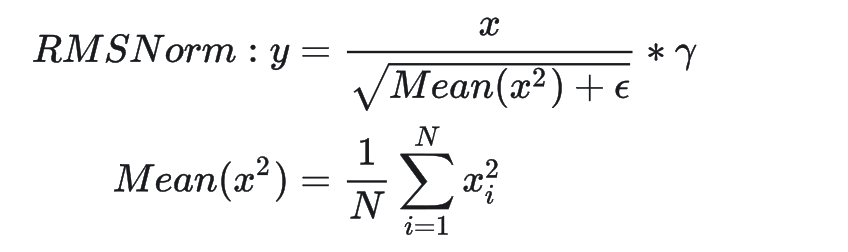

In [7]:
import torch
import torch.nn as nn
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps # ε
        #(dim)
        self.weight = nn.Parameter(torch.ones(dim)) #可学习参数γ

    def _norm(self, x):
        # RMSNorm (B,seq_len,Dim)*（B,seq_len,1) =[broadcast] （B,seq_len,Dim) , rsqrt = 1/sqrt
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        #Dim*(B,seq_len,Dim) = (B,seq_len,Dim)
        return output * self.weight

we want to get Relative position of  K,Q

f is the absolute position , after attention inner product g , we can get the relative position by (m-n)

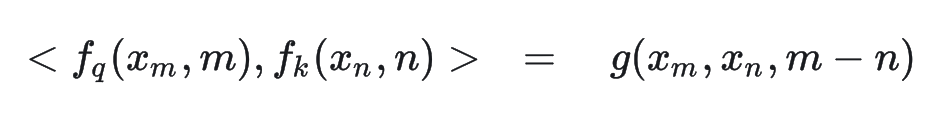

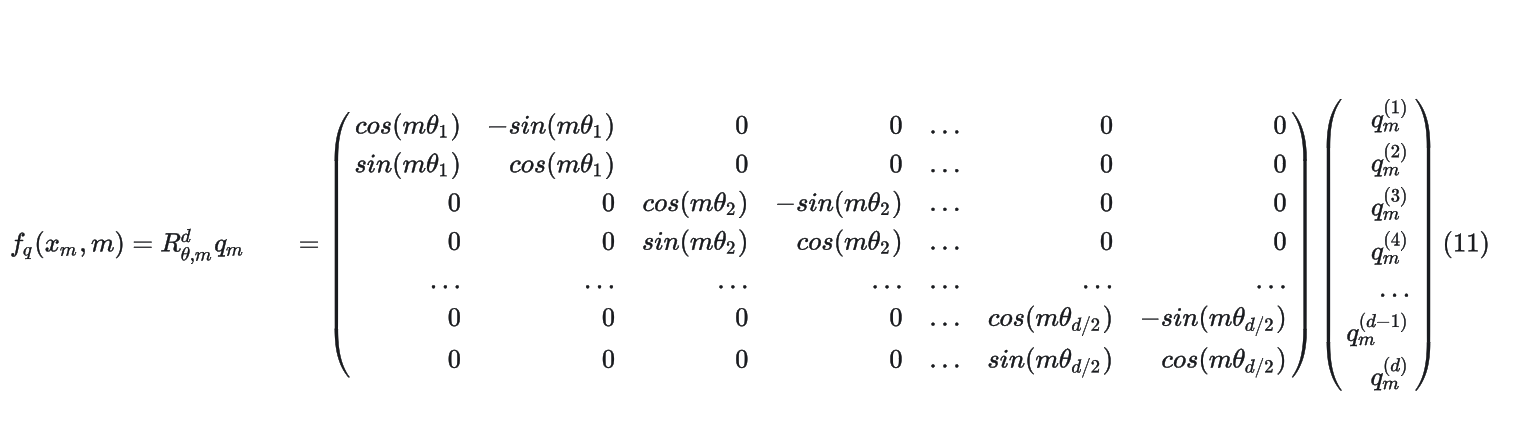

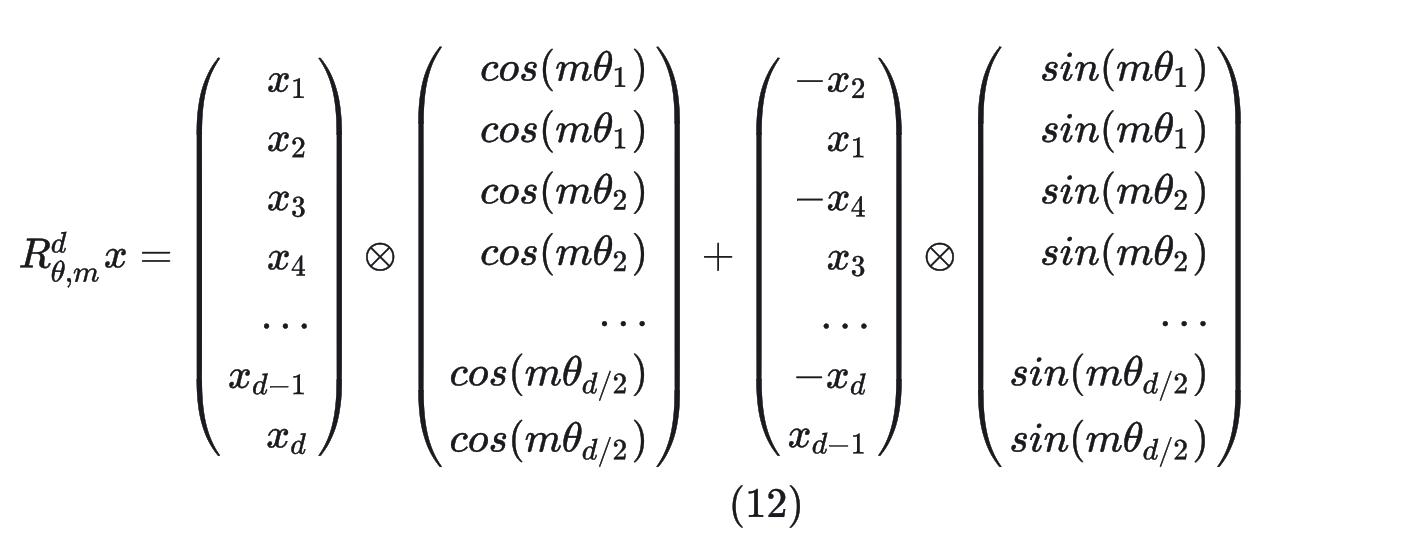

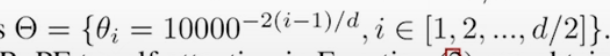

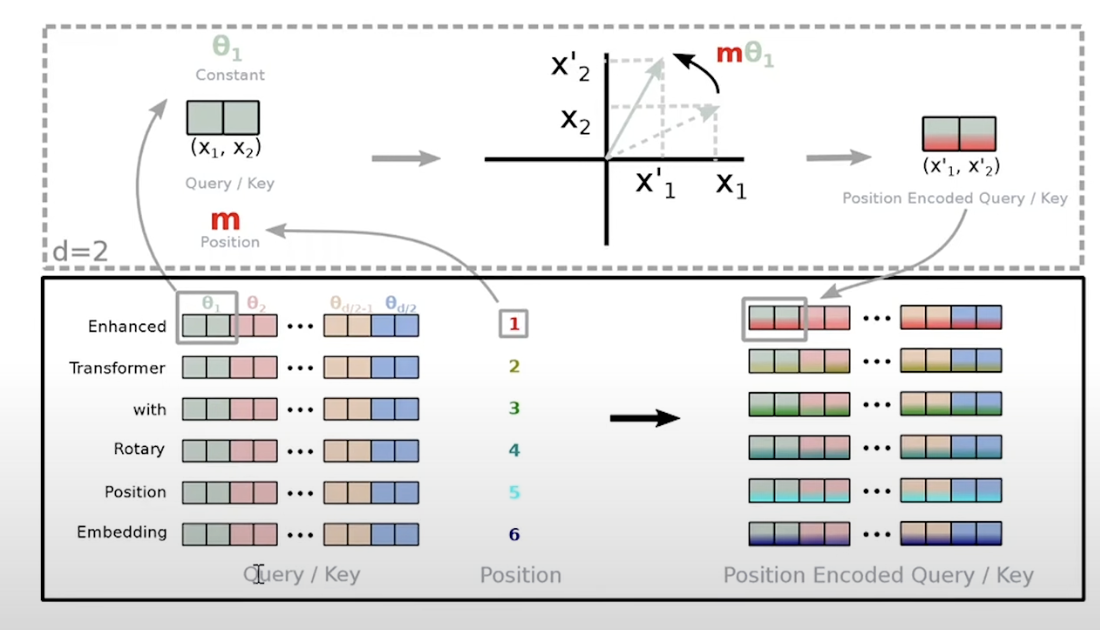

x1...xd are the embedding features

m is the position of the token

theta is the vector based on feature index

In [8]:
def precompute_theta_pos_freq(head_dim: int,seq_len: int , device: str, theta: float = 100000.0 ):
  assert head_dim%2 == 0 , 'dim/2 ,check the head_dim'

  #Bulid theta param theta_i = 10000 ^ (-2(i-1)/head_dim) for i in (1,2,...,head_dim/2)
  #shape : (head_dim/2)
  theta_numerator = torch.argange(0,head_dim,2).float #2(i-1) for i in (1,2....head_dim/2),even
  #shape:(head_dim/2)
  theta = 1/theta**(theta_numerator/head_dim).to(device) #10000 ^ (-2(i-1)/head_dim) for i in (1,2,...,head_dim/2)

  #Build m
  #shape:(seq_len)
  m = torch.arange(0,seq_len)

  #Bulid m*theta
  #shape:(seq_len,head_dim/2)
  freqs = torch.outer(m,theta).float() # m[i]*theta[j]
  #shape:(seq_len,head_dim/2)
  freqs_complex = torch.polar(torch.ones_like(freqs),freqs) #（mag,angle）
  return freqs_complex


def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor, device: str):
    # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
    # Two consecutive values will become a single complex number
    # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # let last dim be 2
    # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. So we need to add the batch dimension and the head dimension
    # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
    # Which results in the rotation of the complex number as shown in the Figure 1 of the paper
    # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
    x_rotated = x_complex * freqs_complex
    # Convert the complex number back to the real number
    # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)







**Encoder block**

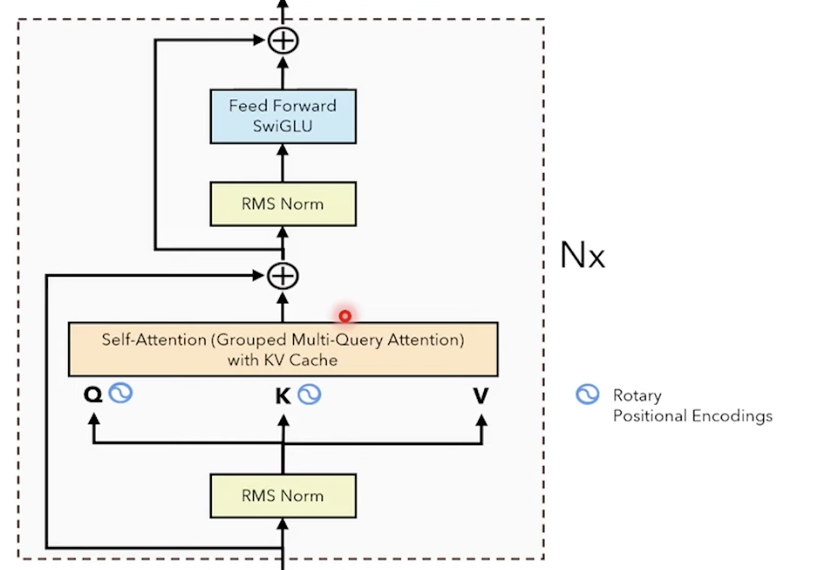

In [9]:
from typing_extensions import Self
class EncoderBlock(nn.Module):
  def __init__(self, args:ModelArgs):
      super().__init__()
      self.n_heads = args.n_heads
      self.dim = args.dim
      self.head_dim = self.dim // self.n_heads
      self.attention = SelfAttention(args)
      self.feed_forward = FeedForward(args)
      #First RMSnorm
      self.attention_norm = RMSNorm(args)
      #Second RMSnorm
      self.ffn_norm = RMSNorm(args)
  def forward(self, x,start_pos:int,freqs_complex:torch.Tensor):
      #(B,seq_len,dim) +(B,seq_len,dim)
      h = x + self.attention(self.attention_norm(x),start_pos,freqs_complex) # each time one token , seq_len=1.Need token position
      out = h + self.feed_forward(self.ffn_norm(h))
      return out

**Self Attention**

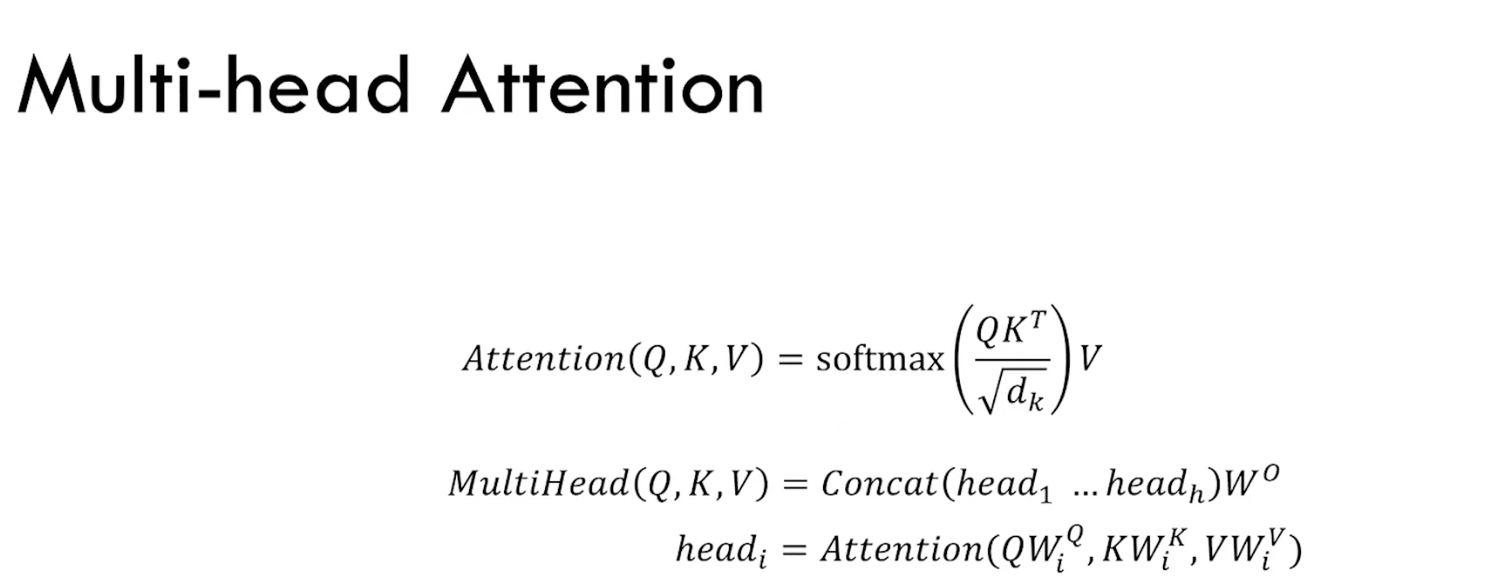

Origin Transformer self attention

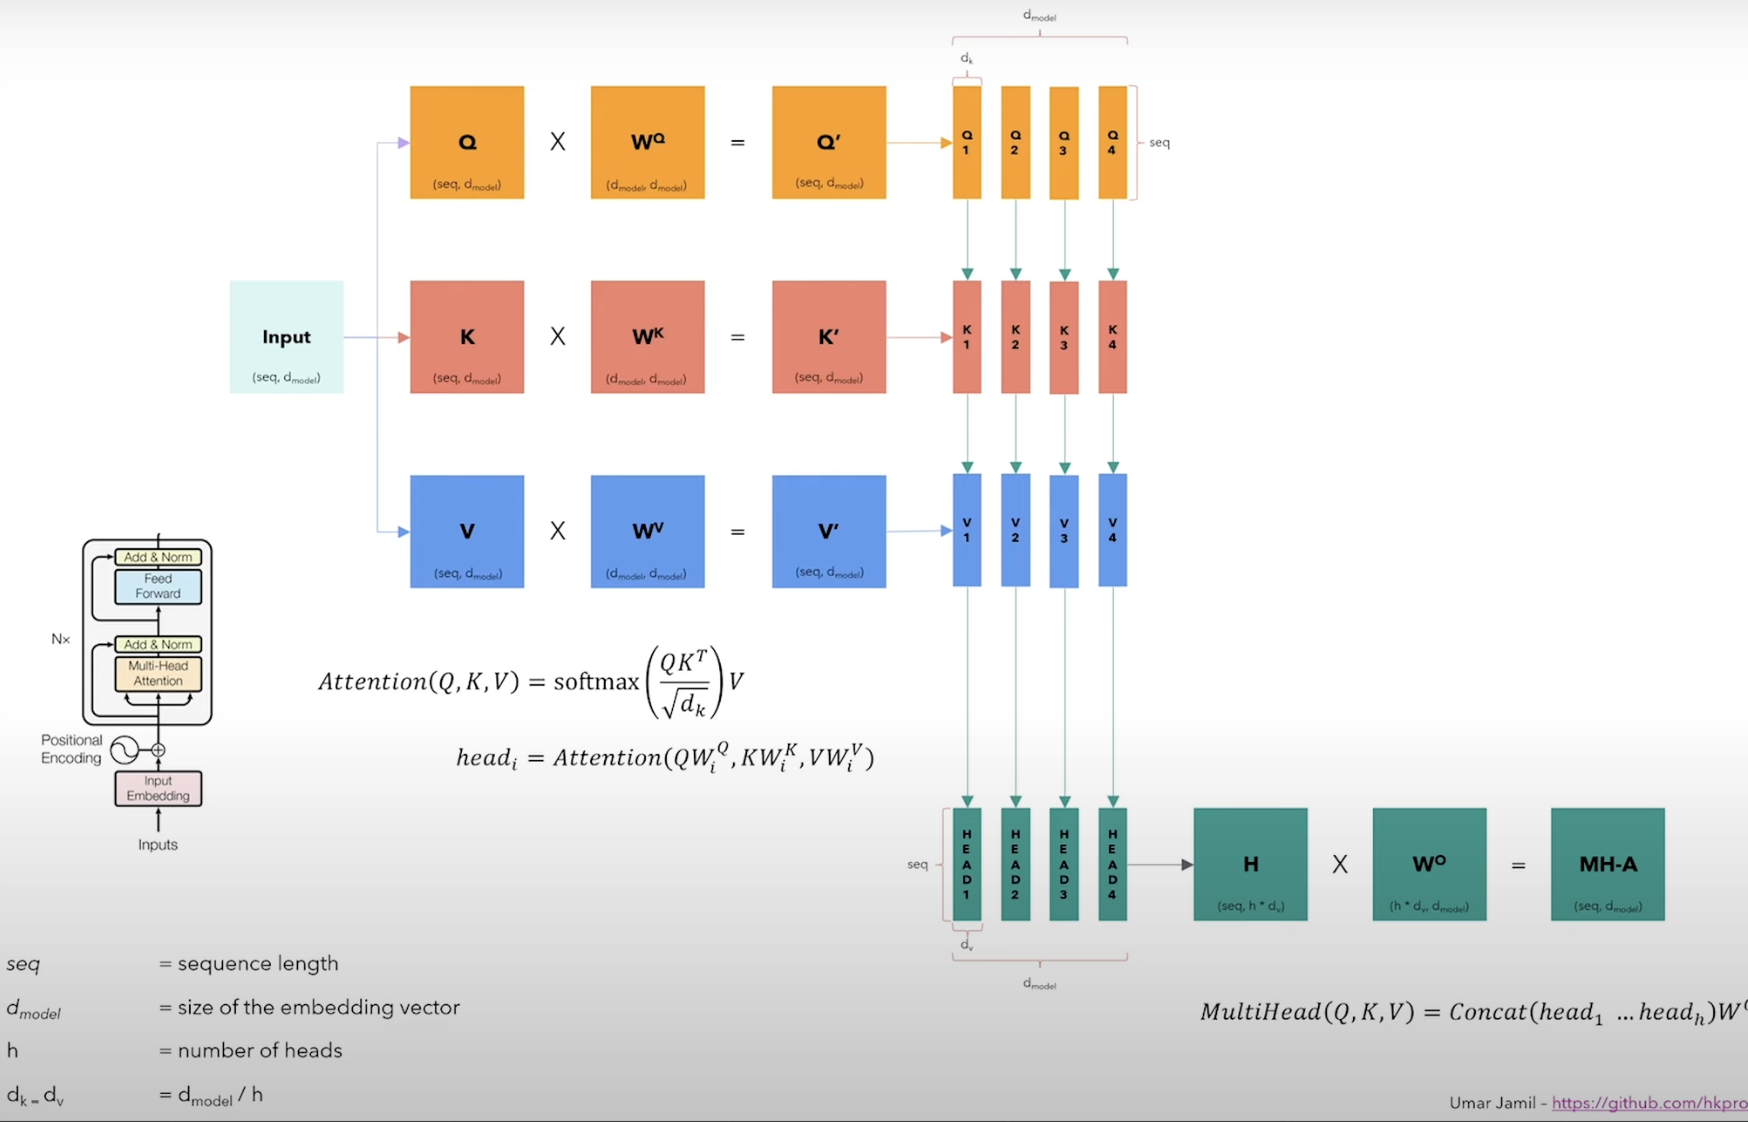

llama self attention

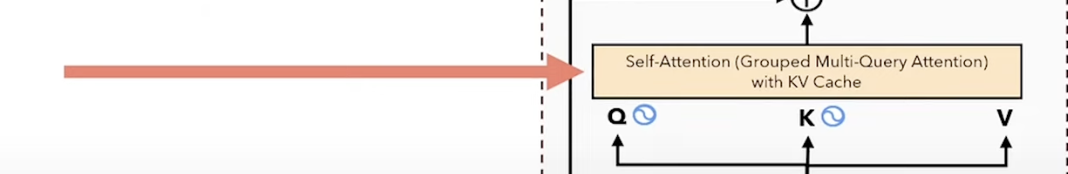

kv-cache

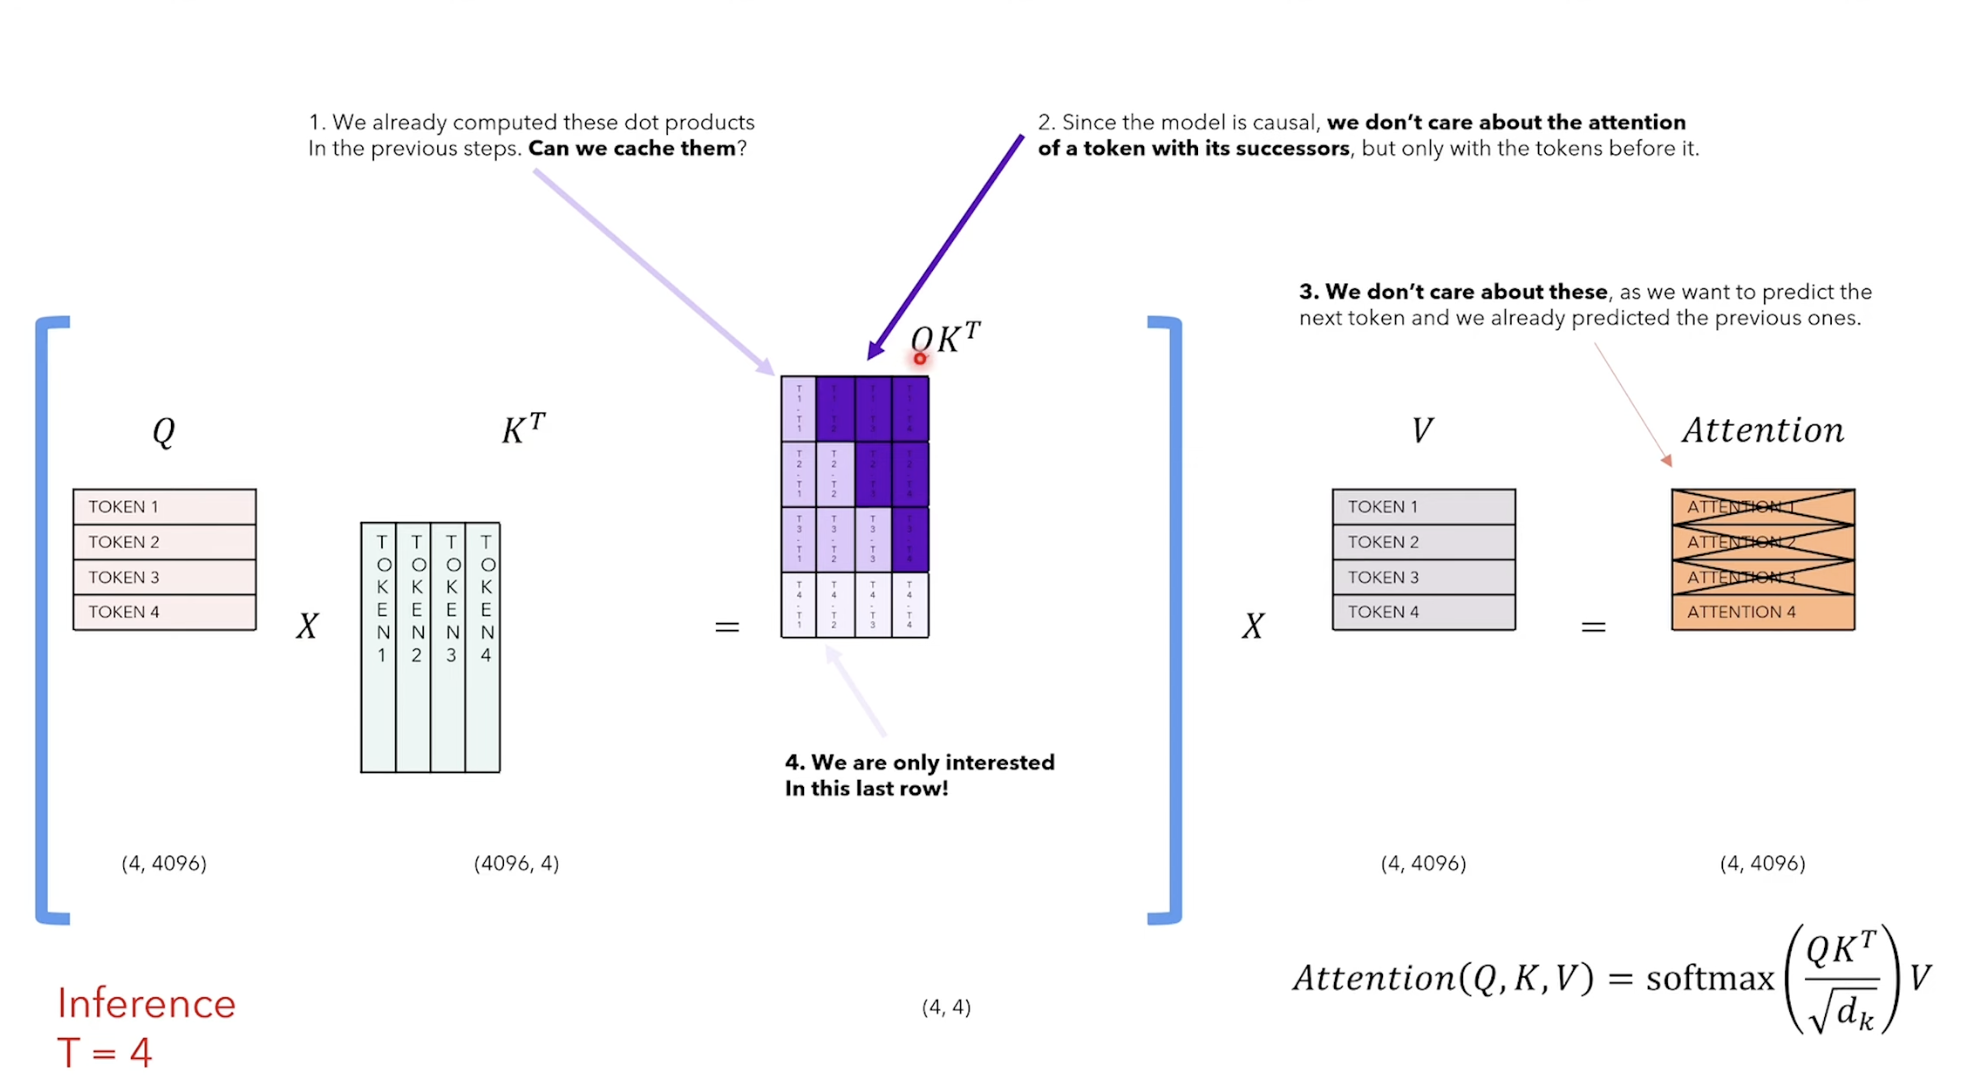

1. recompute very time 2.with mask we do not care  3. only care the latest output

k,v need to ba cached also because q_new need to access the previous token(whole prompt before)

the q_new is the output of last step attention(auto_regression),and append the last output to the kv

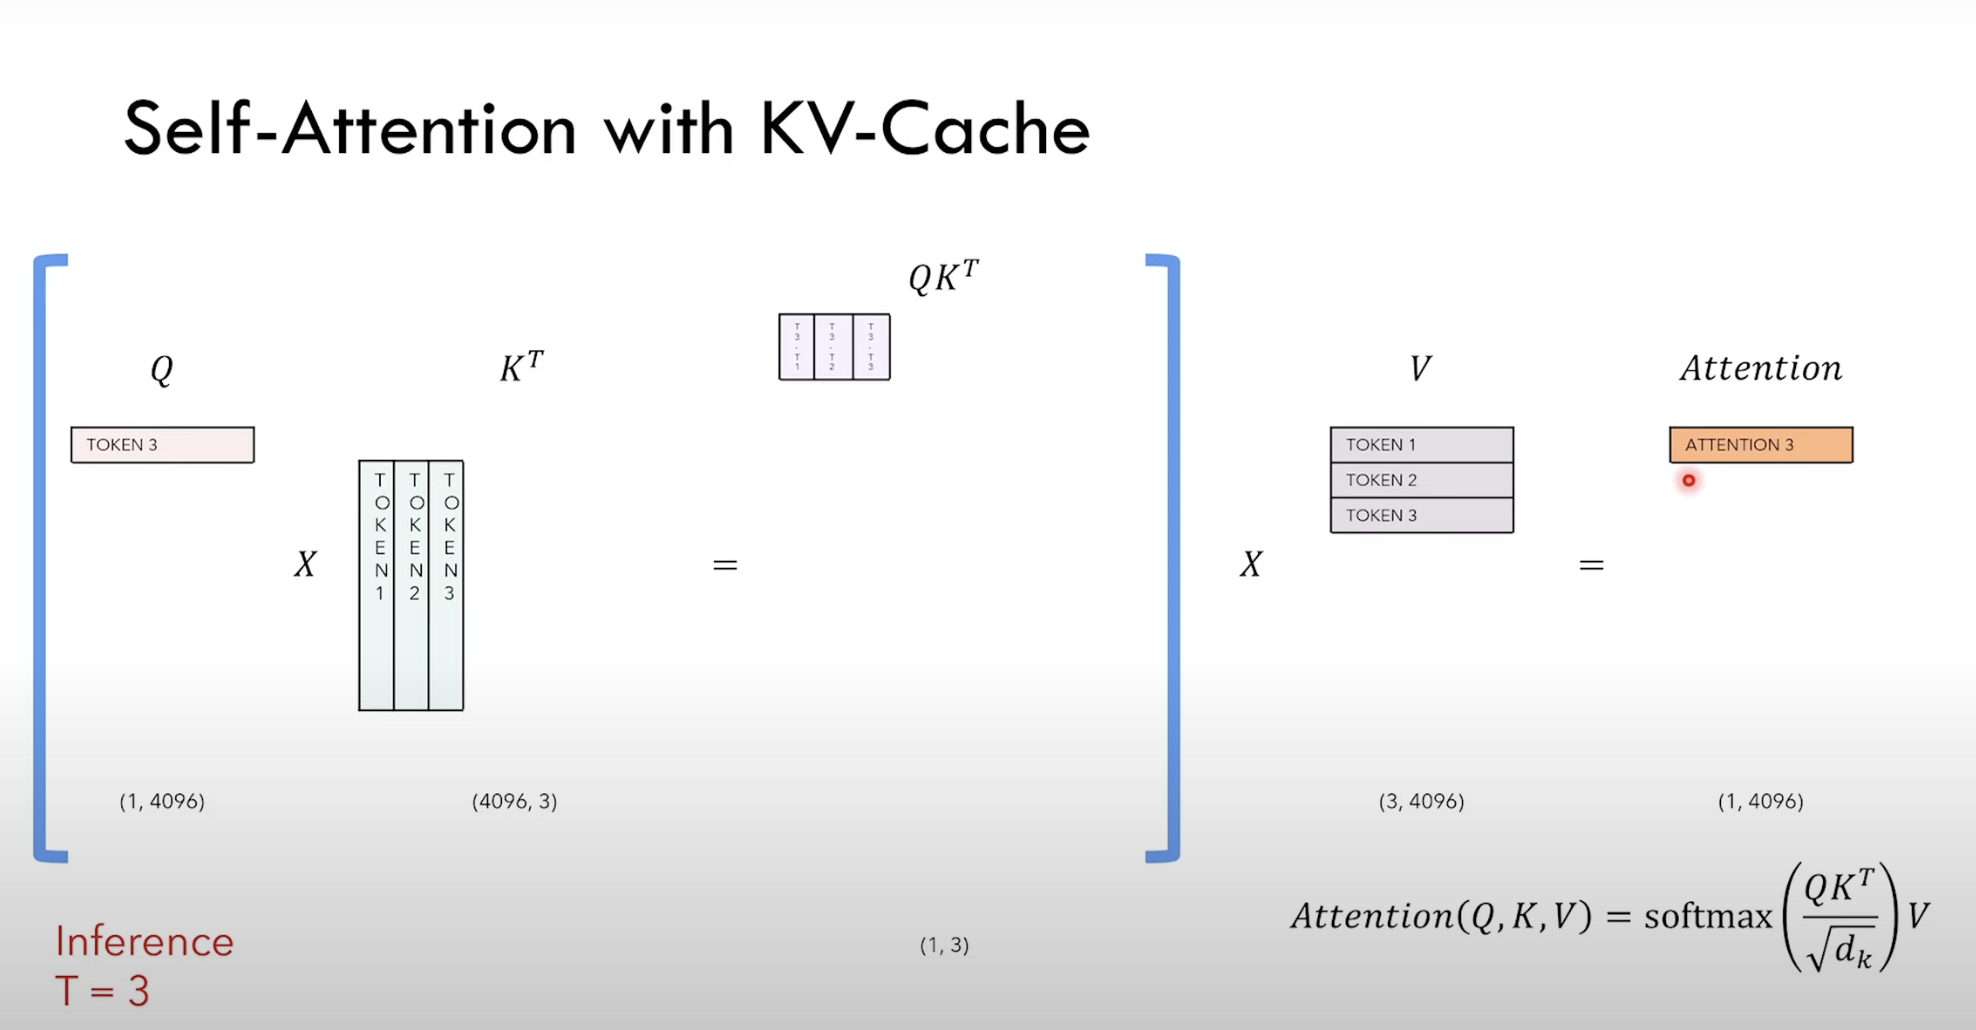

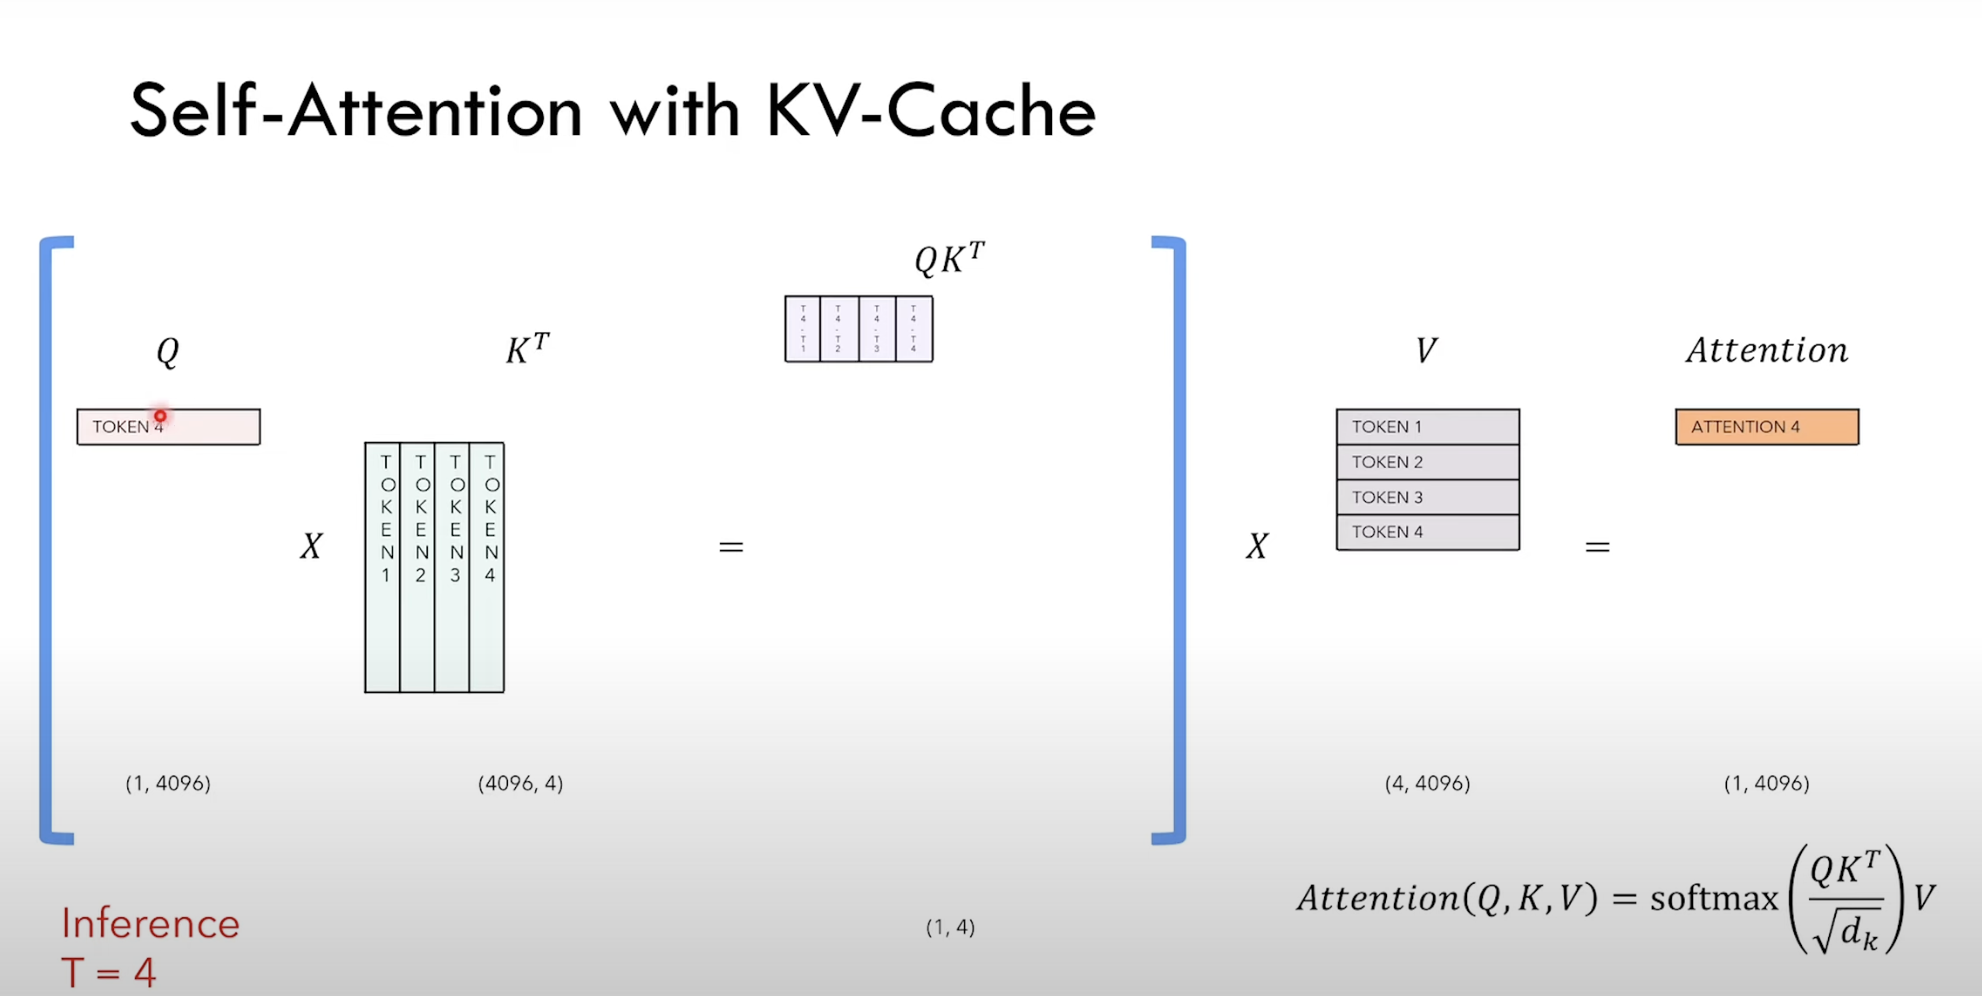

grouped query attention

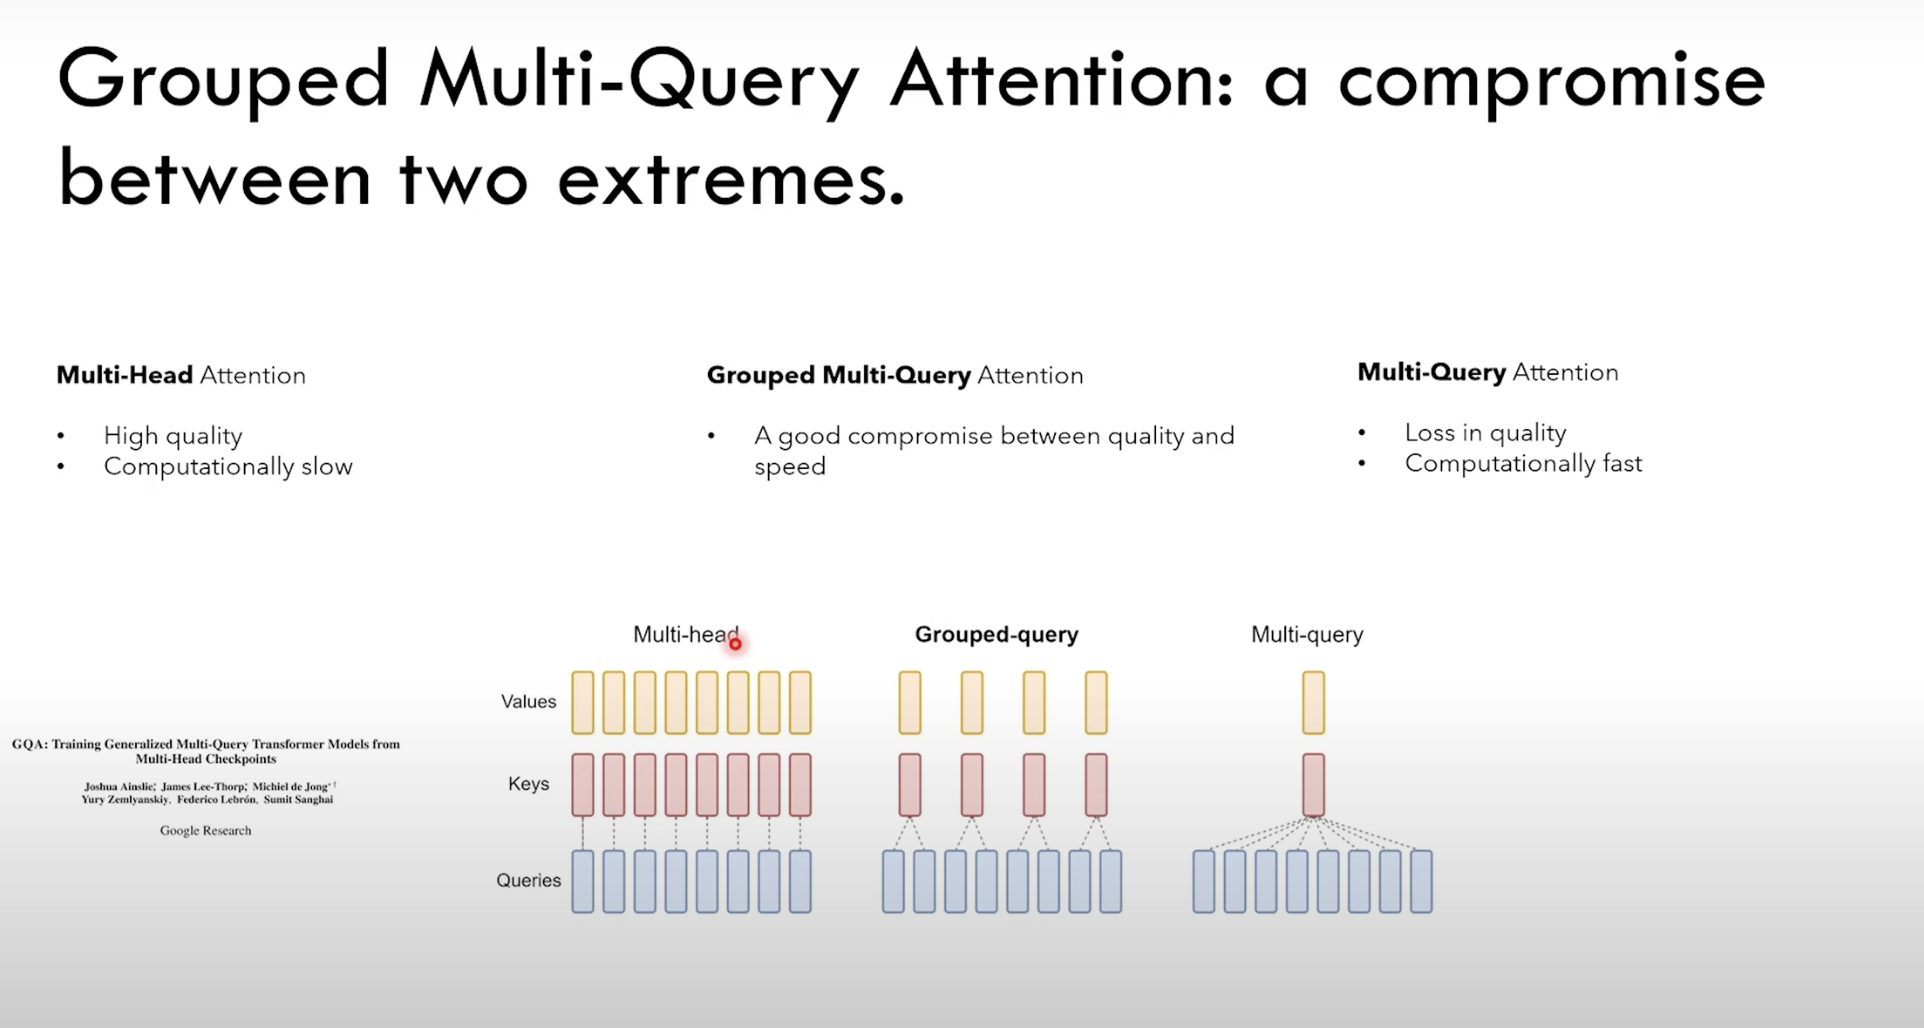

In [13]:

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch_size, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        # (B, Seq_Len, N_KV_Heads, 1, Head_Dim)
        x[:, :, :, None, :]
        # (B, Seq_Len, N_KV_Heads, N_Rep, Head_Dim)
        .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
        # (B, Seq_Len, N_KV_Heads * N_Rep, Head_Dim)
        .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
    )
class SelfAttention(nn.Module):
  def __init__(self,args:ModelArgs):
    super().__init__()

    #Indicates the number of heads of keys and values , because of kv cache the numbers of heads could be different with Q
    self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
    #Indicates the number of heads of queries
    self.n_heads_q = args.n_heads
    #Indicates the repeart ratio of Q heads and K,V heads , because of attention @ keep the same dim in heads dim
    self.n_rep = self.n_heads_q//self.n_kv_heads

    self.head_dim = args.dim//self.n_heads_q
    #linear layer for Q K V and output layer
    self.wq = nn.Linear(args.dim,self.head_dim*self.n_heads_q,bias=False)
    #The output shape of kv should be different from q,beacasue of kv cache
    self.wk = nn.Linear(args.dim,self.head_dim*self.n_kv_heads,bias=False)
    self.wv = nn.Linear(args.dim,self.head_dim*self.n_kv_heads,bias=False)
    #keep the same dim as input,because of residual connecttion
    self.wo = nn.Linear(self.head_dim*self.n_heads_q,args.dim,bias=False)

    #create empty kv cache matrix
    self.cache_k = torch.zeros((args.max_batch_size,args.max_seq_len,self.n_kv_heads,self.head_dim))
    self.cache_v = torch.zeros((args.max_batch_size,args.max_seq_len,self.n_kv_heads,self.head_dim))

#x-->x_k,x_v,x_q--->apply rope to q k---> x_k,x_v cache--> calulate the attention for one Q with all previous k,v[0:start_pos].
#grouped query : differnt numbers of head of Q and K_V , in our case we repeat K_V with the ration to @ with Q in head_dim instead of optimization
  def forward(self,
        x: torch.Tensor,
        start_pos: int,
        freqs_complex: torch.Tensor):
    batch_size, seq_len, _ = x.shape  # (B, 1, Dim)
    #Apply the Wq,Wk,Wv , one head in this step
    #(B,seq_len=1,Dim)-->(B,seq_len=1,n_q_heads*head_dim =dim)
    xq = self.wq(x)
    #(B,seq_len=1,Dim)-->(B,seq_len=1,n_kv_heads*head_dim =dim)
    xk = self.wk(x)
    xv = self.wv(x)

    #view to multi heads,eache head will watch the full sentence（sequence） but part of embedding_dim
    #(B,seq_len=1,dim)--> (B,seq_len=1,n_q_heads,head_dim)
    xq = xq.view(x.shape[0],x.shape[1],self.n_heads_q,self.head_dim)
    #(B,seq_len=1,dim)--> (B,seq_len=1,n_kv_heads,head_dim)
    xk = xk.view(x.shape[0],x.shape[1],self.n_kv_heads,self.head_dim)
    xv = xv.view(x.shape[0],x.shape[1],self.n_kv_heads,self.head_dim)

    #apply Rope to Q and k
    #freqs_complex is recomputed and index by start_pos , keep the same dim
    #(B,seq_len=1,n_q_heads,head_dim)-->(B,seq_len=1,n_q_heads,head_dim)
    xq = apply_rotary_embeddings(xq,freqs_complex,device = x.device)
    #(B,seq_len=1,n_kv_heads,head_dim)-->(B,seq_len=1,n_kv_heads,head_dim)
    xk =apply_rotary_embeddings(xk,freqs_complex,device = x.device)

    # k v cache , replace zero
    self.cache_k[:batch_size,start_pos:start_pos+seq_len] =xk
    self.cache_v[:batch_size,start_pos:start_pos+seq_len] =xv

    #Extract all [:start_pos] for attention calculation
    #(batch_size,start_pos,n_kv_heads,self.head_dim)
    keys = self.cache_k[:batch_size,:start_pos]
    values = self.cache_v[:batch_size,:start_pos]


    #Repeat keys,values from n_head_kv to n_head_q
    #(batch_size,start_pos,n_kv_heads,head_dim) --->(batch_size,start_pos,n_q_heads,head_dim)
    keys = repeat_kv(keys,self.n_rep)
    values = repeat_kv(values,self.n_rep)




    #reshape for attention calculation
    #(B,seq_len=1,n_q_heads,head_dim)-->(B,n_q_heads,seq_len=1,head_dim)
    xq = xq.transpose(1,2)
    #(B,n_q_heads,all_previous_seq_len,head_dim)
    keys = keys.transpose(1,2)
    values = values.transpose(1,2)


    #calculate the attention
    #(B,n_q_heads,seq_len=1,head_dim)@ (B,n_q_heads,head_dim,all_previous_seq_len=start_pos)-->(B,n_q_heads,seq_len=1,all_previous_seq_len=start_pos)
    scores = torch.matmul(xq,keys.transpose(2,3))/math.sqrt(self.head_dim)
    socres = F.softmax(scores.float(),dim=-1).tpye(xq.dtype)
    #(B,n_q_heads,seq_len=1,all_previous_seq_len=start_pos)@(B,n_q_heads,all_previous_seq_len=start_pos,head_dim)-->(B,H_q,1,head_dim)
    output = torch.matmul(scores,values)

    #concatenate the heads
    # (B,h_q,1,head_dim)-->(B,1,dim)
    output = output.transpose(1,2).contiguous().view(x.shape[0],x.shape[1],self.head_dim*self.n_heads_q)

    #(B,1,dim)-->(B,1,dim),only output one token
    return self.wo(output)




**FFN**

origin Transformer : 512-->2048-->512

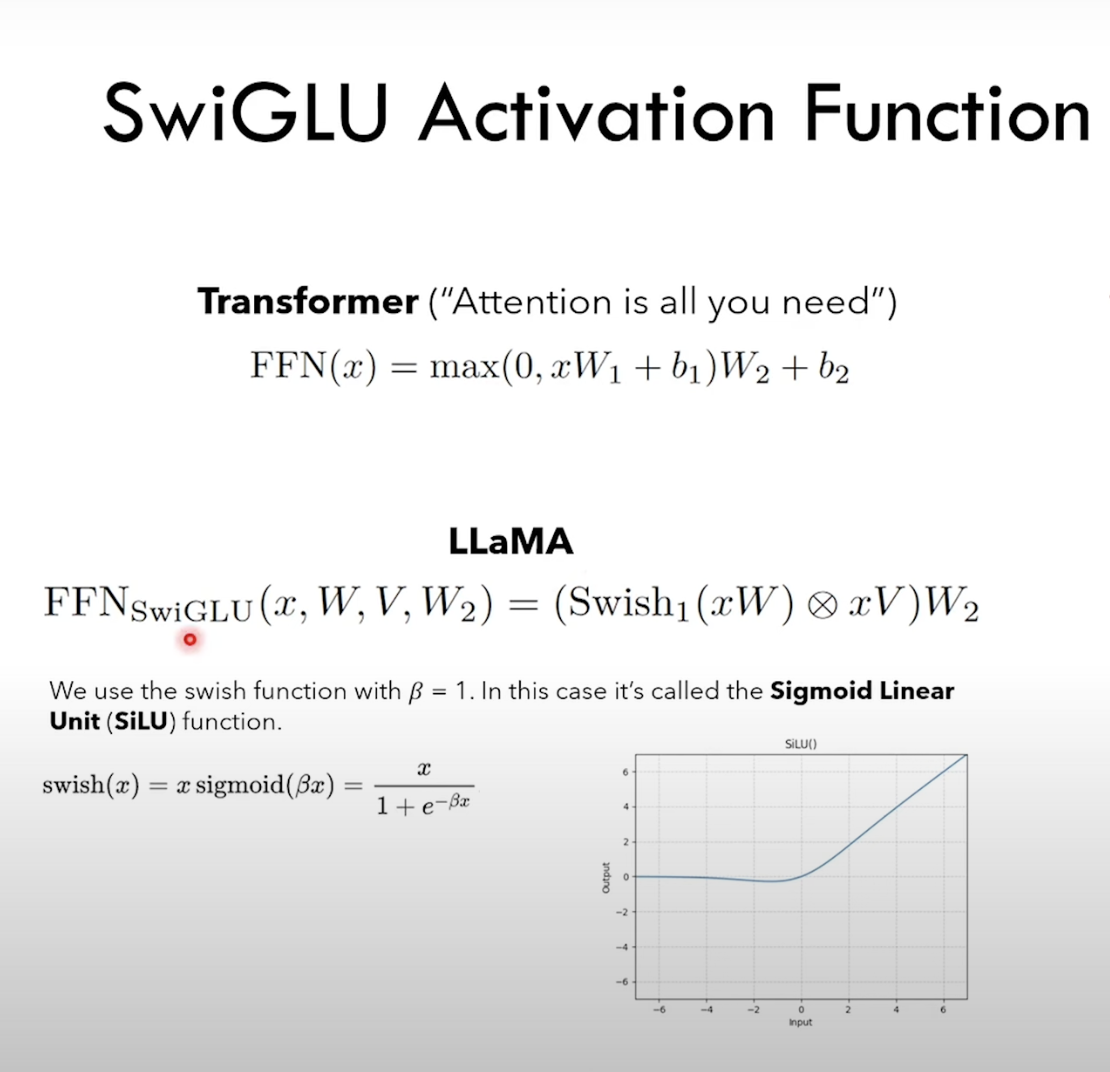

In [16]:
 class FeedForward(nn.Module):
    def __init__(
        self,
        args: ModelArgs
    ):
        super().__init__()

        hidden_dim = 4 * args.dim
        hidden_dim = int(2 * hidden_dim / 3)
        if args.ffn_dim_multiplier is not None:
            hidden_dim = int(args.ffn_dim_multiplier * hidden_dim)
        # Round the hidden_dim to the nearest multiple of the multiple_of parameter
        hidden_dim = args.multiple_of * ((hidden_dim + args.multiple_of - 1) // args.multiple_of)

        self.w1 = nn.Linear(args.dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, args.dim, bias=False)
        self.w3 = nn.Linear(args.dim, hidden_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        swish = F.silu(self.w1(x))
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        x_V = self.w3(x)
        # (B, Seq_Len, Hidden_Dim) * (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Hidden_Dim)
        x = swish * x_V
        # (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Dim)
        x = self.w2(x)
        return x